In [1]:
%matplotlib inline

import bt
import numpy as np

In [2]:
data = bt.get("spy,vti,upro", start="2010-01-01")
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  spy        vti      upro
Date                                      
2010-01-04  85.515633  43.463146  2.081381
2010-01-05  85.742004  43.629997  2.099268
2010-01-06  85.802376  43.690655  2.105317
2010-01-07  86.164543  43.872650  2.130966
2010-01-08  86.451286  44.016769  2.151746


In [3]:
spy = bt.Strategy('spy', [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["spy"]),
    bt.algos.WeighEqually(),
    bt.algos.CapitalFlow(1_000),
    bt.algos.Rebalance(),
])
spy_test = bt.Backtest(spy, data, initial_capital=0)

In [4]:
vti_upro = bt.Strategy('vti+upro', [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["vti", "upro"]),
    bt.algos.WeighEqually(),
    bt.algos.CapitalFlow(1_000),
    bt.algos.Rebalance(),
])
vti_upro_test = bt.Backtest(vti_upro, data, initial_capital=0)

In [37]:
class BuyOnlyRebalance(bt.algos.Algo):
    def __call__(self, target):
        if "weights" not in target.temp: return True

        targets = target.temp["weights"]

        total_capital = target.value
        current_positions_value = 0
        for cname in target.children:
            c = target.children[cname]
            if target.fixed_income:
                current_positions_value += c.notional_value
            else:
                current_positions_value += c.value

        # Available cash for new purchases
        available_cash = total_capital - current_positions_value
        assert available_cash > 0, "we have influx of capital each cycle..."
        if available_cash <= 0: return True

        target_values = {asset: total_capital * weight for asset, weight in targets.items()}
        # Calculate how much to *buy* of each asset
        for asset, target_value in target_values.items():
            # Get current value of this asset
            if asset in target.children:
                c = target.children[asset]
                current_value = c.notional_value if target.fixed_income else c.value
            else:
                current_value = 0

            # Calculate how much more we need to buy
            amount_to_buy = target_value - current_value
            
            # Only buy if we have positive amount and available cash
            if amount_to_buy > 0 and available_cash > 0:
                # Limit by available cash
                amount_to_buy = min(amount_to_buy, available_cash)
                
                # Allocate the amount
                target.allocate(amount_to_buy, child=asset, update=False)
                
                # Reduce available cash
                available_cash -= amount_to_buy
        # Now update
        target.root.update(target.now)
        
        return True

vti_upro_buy_only = bt.Strategy('vti+upro buy only', [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["vti", "upro"]),
    bt.algos.WeighEqually(),
    bt.algos.CapitalFlow(1_000),
    BuyOnlyRebalance(),
])
vti_upro_buy_only_test = bt.Backtest(vti_upro_buy_only, data, initial_capital=0)

In [38]:
vti_upro_80 = bt.Strategy("vti+upro 80% upro", [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["vti", "upro"]),
    bt.algos.WeighSpecified(vti=.2, upro=.8),
    bt.algos.CapitalFlow(1_000),
    bt.algos.Rebalance(),
])
vti_upro_80_test = bt.Backtest(vti_upro_80, data, initial_capital=0)

In [39]:
res = bt.run(spy_test, vti_upro_test, vti_upro_buy_only_test, vti_upro_80_test)
res.display()

100%|██████████| 4/4 [00:00<00:00,  9.31it/s]

Stat                 spy         vti+upro    vti+upro buy only    vti+upro 80% upro
-------------------  ----------  ----------  -------------------  -------------------
Start                2010-01-03  2010-01-03  2010-01-03           2010-01-03
End                  2025-08-22  2025-08-22  2025-08-22           2025-08-22
Risk-free rate       0.00%       0.00%       0.00%                0.00%

Total Return         639.40%     2194.40%    1968.12%             3627.78%
Daily Sharpe         0.83        0.76        0.73                 0.75
Daily Sortino        1.29        1.18        1.12                 1.16
CAGR                 13.65%      22.19%      21.38%               26.04%
Max Drawdown         -33.70%     -57.75%     -60.40%              -69.60%
Calmar Ratio         0.41        0.38        0.35                 0.37

MTD                  2.09%       3.85%       4.19%                4.73%
3m                   10.99%      21.37%      23.46%               27.62%
6m                   8

<Axes: title={'center': 'Equity Progression'}>

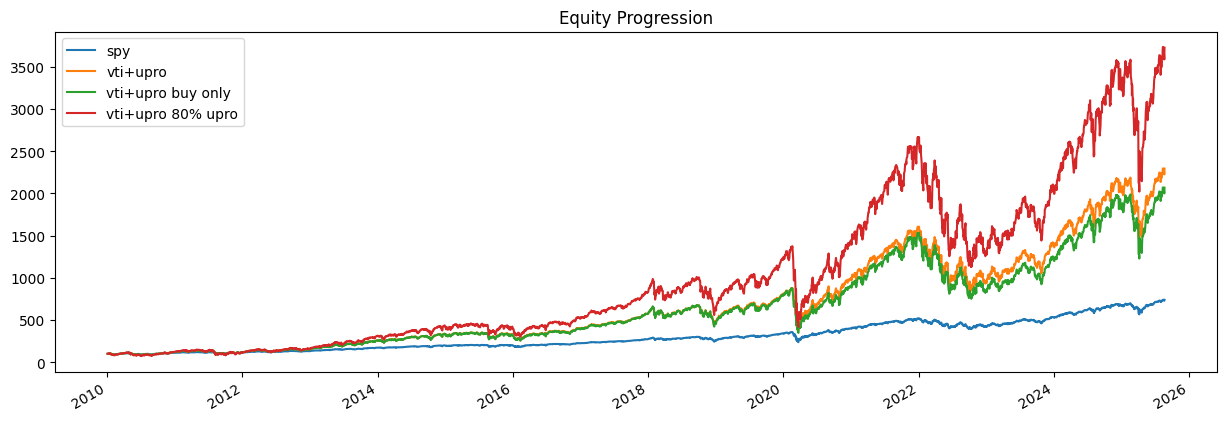

In [30]:
res.plot()